<a href="https://colab.research.google.com/github/IFuentesSR/RSE_drought/blob/main/AVHRR_MODIS_NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Continuous NDVI collection from AVHRR and MODIS

In [2]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=c460RJIVJZVJin8ExOCn290mPcUi1A_0kfRDR2fDTLk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g6WKu1ApYc65STfpFzcGEbUAtRUvfJFDsxnJlEwIzJZHcKxfILuUT8

Successfully saved authorization token.


In [39]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Defining functions to work with collections

In [34]:
def mask_Gi(img):
  properties = img.propertyNames()
  return img.updateMask(img.gt(-1)).copyProperties(img, properties)


def temporal_aggregation_GIMMS(collection):
    def inner(year):
        months = ee.List.sequence(1,12)
        def month_iteration(m):
            date = ee.Date.fromYMD(year, m, 1)
            return collection.select('ndvi').filterDate(date, date.advance(1, 'month')).mean().setMulti({'system:time_start': date.millis(), 'system:index':date.format('YYYY_MM_dd'), 'month': m})
        return months.map(month_iteration)
    return inner


def temporal_aggregation_MODIS(collection, image):
    def inner(year):
        months = ee.List.sequence(1,12)
        def month_iteration(m):
            date = ee.Date.fromYMD(year, m, 1)
            mean = collection.select('NDVI').filterDate(date, date.advance(1, 'month')).mean().multiply(0.0001)
            mean = mean.reproject(image.projection(), ee.List([0.0833333333,0,-180,0,-0.08333333333,90]))
            return mean.setMulti({'system:time_start': date.millis(), 'system:index':date.format('YYYY_MM_dd'), 'month':ee.Number(m)})
        return months.map(month_iteration)
    return inner


def join(collection):
    def wrap(img):
        date = img.get('system:time_start')
        img_retrieve = img.addBands(collection.filter(ee.Filter.eq('system:time_start', date)).first().rename('MOD'))
        return img_retrieve.copyProperties(img, ['system:time_start', 'system:index', 'month'])
    return wrap


def get_OLS_coeffs(collection, reducer):
    def wrap(n):
        imgs = collection.filter(ee.Filter.eq('month', ee.Number(n)))
        coefs = imgs.select(['MOD', 'ndvi']).reduce(reducer).set('month', n)
        return coefs
    return wrap


def Mi2Gi(monthly_coefficients):
    def wrap(img):
        month = ee.Number(img.get('month'))
        coeffs = monthly_coefficients.filter(ee.Filter.eq('month', month)).first()
        predicted = coeffs.select('offset').add(coeffs.select('scale').multiply(img)).rename('ndvi')
        return predicted.copyProperties(img, ['system:time_start', 'system:index'])
    return wrap


def sample_collection(geo):
    def wrap(img):
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
        ndvi = img.reduceRegion('first', geo, 1000).values().get(0)
        return ee.Feature(None, {'date':date, 'ndvi':ndvi})
    return wrap


### Calling collections and setting parameters for OLS

In [36]:
Gi = ee.ImageCollection("NASA/GIMMS/3GV0")
Mi = ee.ImageCollection("MODIS/006/MOD13A2")
geo = ee.Geometry.Point([149.5462, -30.2282])
months = ee.List.sequence(1,12)
years = ee.List.sequence(2001, 2011)

## Monthly aggregation of data

In [25]:
Gi_sub = Gi.map(mask_Gi)
GiAggs = years.map(temporal_aggregation_GIMMS(Gi_sub))
GiAggs = ee.ImageCollection.fromImages(GiAggs.flatten())

In [26]:
MiAggs = years.map(temporal_aggregation_MODIS(Mi, GiAggs.first()))
MiAggs = ee.ImageCollection.fromImages(MiAggs.flatten())

### Mapping AVHRR and MODIS NDVI

In [32]:
AVHRR_ex = GiAggs.filterDate('2005-04-01', '2012-01-01').first().getMapId({'min': 0, 'max': 1})
MODIS_ex = MiAggs.filterDate('2005-04-01', '2012-01-01').first().getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[-30.63, 149.91], zoom_start=2)
folium.TileLayer(
    tiles=AVHRR_ex['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='AVHRR',
  ).add_to(map)
folium.TileLayer(
    tiles=MODIS_ex['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='MODIS',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

## Calculating monthly OLS coefficients for future prediction (using 10 years; 2001-2011)

In [51]:
joint = GiAggs.map(join(MiAggs))

ols = ee.Reducer.linearFit()
monthCoefs = months.map(get_OLS_coeffs(joint, ols))
monthCoefs = ee.ImageCollection.fromImages(monthCoefs)

## Converting MODIS to AVHRR signal based on monthly OLS and merging collections

In [57]:
AllGiAggs = ee.List.sequence(1982, 2013).map(temporal_aggregation_GIMMS(Gi_sub))
AllGiAggs = ee.ImageCollection.fromImages(AllGiAggs.flatten())
NewMiAggs = ee.List.sequence(2014, 2020).map(temporal_aggregation_MODIS(Mi, GiAggs.first()))
NewMiAggs = ee.ImageCollection.fromImages(NewMiAggs.flatten())
GiFromMi = NewMiAggs.map(Mi2Gi(monthCoefs))
AllGiAggs = AllGiAggs.merge(GiFromMi)

### Sampling locations for testing

In [58]:
samples = AllGiAggs.map(sample_collection(geo))
samples = samples.getInfo()

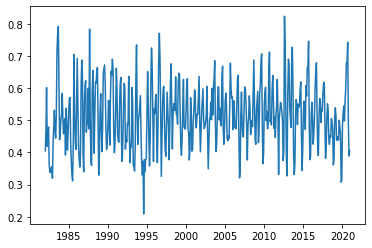

In [59]:
dates = [pd.to_datetime(n['properties']['date']) for n in samples['features']]
ndvis = [n['properties']['ndvi'] for n in samples['features']]
plt.plot(dates, ndvis)